In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class Delitos():
    def __init__(self, path):
        self.data = pd.read_csv(path+'delitos_2017_2022.csv')
        self.delitos = self.data['GRUPO DELICTUAL / DELITO'].values
        self.processed = False
        self.date_of_interest = []
        self.months = {
            'Enero': 1,
            'Febrero': 2,
            'Marzo': 3,
            'Abril': 4,
            'Mayo': 5,
            'Junio': 6,
            'Julio': 7,
            'Agosto': 8,
            'Septiembre': 9,
            'Octubre': 10,
            'Noviembre': 11,
            'Diciembre': 12
        }
        
    def process_data(self):
        """
        Esta función invierte el orden de las columnas y filas de la tabla, dejando fechas como filas y delitos como columnas.
        También las fechas las transforma a datetime "2018_2" -> "2018-02-01" (yyyy-mm-dd)
        """
        if(not self.processed):
            try:
                self.data = self.data.iloc[::-1]
                self.data = self.data.T
                self.data.columns = self.data.iloc[0]
                self.data = self.data.iloc[1:]
                self.data = self.data.reset_index()
                self.data['index'] = self.data['index'].apply(lambda x: datetime.strptime(x, '%Y_%m'))
                # rename index to fecha
                self.data = self.data.rename(columns={'index': 'fecha'})
                self.processed = True

                self.years = self.data['fecha'].dt.year.unique()
                print('Los datos han sido procesados correctamente.')
            except(Exception):
                print("Error al procesar los datos.")
                print(Exception)
        else:
            print("Los datos ya han sido procesados.")
    

    def show_delitos(self):
        """
        Muestra los delitos disponibles.
        """
        print(f'En total hay {len(self.delitos)} delitos. Sin orden de relevancia son los siguientes:')
        for i, delito in enumerate(self.delitos):
            print('{}. {}'.format(i+1, delito))

    def show_ordered_delitos(self, year=None, month=None):
        """
        Muestra el Top 10 delitos, ordenados por ocurrencia (mayor a menor), en base a un año, mes o año y mes especificado.
        Por defecto muestra el top 10 de la suma de todos los años y meses.
        Parameters
            year (optional) = 2018  (int)
            month (optional) = 'Enero' (str)
        """
        if(not self.processed):
            print("Debes procesar los datos antes de pedir esta información, utiliza: .process_data() e intenta nuevamente.")
            return
        
        # Caso 1. Se especifica un año
        if (year in self.years):
            data_temp = self.data[self.data['fecha'].dt.year == year]

            # Caso 1.1. Se especifica un año y un mes (year=2018, month='Enero')
            if(month in self.months):
                data_temp = data_temp[data_temp['fecha'].dt.month == self.months[month]]
                print('Delitos ordenados por ocurrencia en {} de {}:'.format(month, year))
                print(data_temp.sum().sort_values(ascending=False)[:])
                return
            
            # Caso 1.2. Se especifica un año y pero no un mes (year=2018, month=None)
            else:
                print('Delitos ordenados por ocurrencia en {}:'.format(year))
                print(data_temp.sum(axis=0).sort_values(ascending=False)[:])
                return

        # Caso 2. No se especifica un año pero si un mes(year=None, month='Enero')
        elif (month in self.months):
            print('Delitos ordenados por ocurrencia en {}:'.format(month))
            print('Años: {}'.format(self.years))
            print(self.data[self.data['fecha'].dt.month == self.months[month]].sum(axis=0).sort_values(ascending=False)[:])
            return
        
        # Caso default 1: mostrar todos los delitos de todos los años y meses
        # No se especifica ni un año ni un mes (year=None, month=None)
        if (year == None and month == None):
            print('Delitos ordenados por ocurrencia en todos los años y meses:')
            print('Años: {}'.format(self.years))
            print(self.data.sum().sort_values(ascending=False).head(10))
            return
        
        # Caso default 2: El año o mes especificado no existe, no se encuentra (year=2081, month='January')
        print('El año o mes especificado no existe o no se encuentra, intenta nuevamente.')
        print('Delitos ordenados por ocurrencia en todos los años y meses:')
        print('Años: {}'.format(self.years))
        print(self.data.sum().sort_values(ascending=False).head(10))
        return
    
    # --------------------------------------------------------------------
    # --- Funciones para mostrar gráficos generales (todas las fechas) ---
    # --------------------------------------------------------------------

    def general_bar(self, delito, date_interest=False, ax=None):
        """
        Genera un gráfico de barras con el delito especificado.
        Parameters
            delito = 'Homicidios' (str)
            date_interest: Si es True, muestra las fechas de interés en el gráfico. (self.date_of_interest)
            ax (optional) = ax (matplotlib.axes._subplots.AxesSubplot)
        Returns
            ax (matplotlib.axes._subplots.AxesSubplot)
        """
        if(not self.processed):
            print("Debes procesar los datos antes de graficar, utiliza: .process_data() e intenta nuevamente.")
            return
        # - Validamos delito -
        if (delito not in self.delitos):
            print('El delito especificado no existe, intenta nuevamente.')
            return

        if(ax == None):
            fig, ax = plt.subplots(figsize=(16, 5));
            
        # - Tipo de plot -
        ax.bar(self.data['fecha'], self.data[delito], color='steelblue', width=32);

        # - Información del plot -
        ax.set_title(delito, fontsize=20, fontweight= 'bold');
        ax.set_xlabel('fecha', fontsize=16, fontweight= 'regular');
        ax.set_ylabel('cantidad', fontsize=16, fontweight= 'regular');
        
        # - xticks years -
        ax.set_xticks([datetime(year, 1, 1) for year in self.years]);
        ax.set_xticklabels([ str(year) for year in self.years], fontsize=13, fontweight= 'regular');
        
        # - Grid -
        ax.set_ylim(min(self.data[delito]-2), max(self.data[delito])+2);
        for year in self.years:
            ax.axvline(datetime(year, 1, 1), linestyle=':' , linewidth=0.5);

        ax.grid(linestyle='-', linewidth=0.3);

        # --- Date interest ---
        if (date_interest):
            self.plt_date_interest(delito, ax)
        return ax;
    
    def general_plot(self, delito, date_interest=False, ax=None):
        """
        Genera un gráfico de linea con el delito especificado.
        Parameters:
            date_interest: Si es True, muestra las fechas de interés en el gráfico. (self.date_of_interest).
            delito = 'Homicidios' (str)
            ax (optional) = ax (matplotlib.axes._subplots.AxesSubplot)
        Returns
            ax (matplotlib.axes._subplots.AxesSubplot)
        """
        if(not self.processed):
            print("Debes procesar los datos antes de graficar, utiliza: .process_data() e intenta nuevamente.")
            return
        # - Validamos delito -
        if (delito not in self.delitos):
            print('El delito especificado no existe, intenta nuevamente.')
            return

        if(ax == None):
            fig, ax = plt.subplots(figsize=(16, 5));

        # - Tipo de plot -
        ax.plot(self.data['fecha'], self.data[delito]);

        # - Información del plot -
        ax.set_title(delito, fontsize=20, fontweight= 'bold');
        ax.set_xlabel('fecha', fontsize=16, fontweight= 'regular');
        ax.set_ylabel('cantidad', fontsize=16, fontweight= 'regular');

        # - xticks years -
        ax.set_xticks([datetime(year, 1, 1) for year in self.years]);
        ax.set_xticklabels([ str(year) for year in self.years], fontsize=13, fontweight= 'regular');

        # --- Date interest ---
        if (date_interest):
            ax = self.plt_date_interest(delito, ax)
        return ax;
    
    # -------------------------------------------------------
    # --- Funciones para mostrar gráficos por año y/o mes ---
    # -------------------------------------------------------

    def line(self, delito, years_to_graph, months_to_graph= None, colors=['#5EB1BF', '#F2B134', '#F07C5F', '#81B29A', '#3D405B','#F2CC8F'], ax = None, bbx_a=None):
        """
        Compara los delitos en base a años y meses especificados y grafica un gráfico de linea.
        Parameters:
            delito = 'Homicidios' (str)
            years_to_graph = [2017, 2018, 2019] (list)
            months_to_graph = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] (list)
            colors = ['#5EB1BF', '#F2B134', '#F07C5F', '#81B29A', '#3D405B','#F2CC8F'] (list)
            ax (optional) = ax (matplotlib.axes._subplots.AxesSubplot)
            bbx_a (optional) = (x, y) (tuple) Ajusta la posición de la leyenda.
        Returns
            ax (matplotlib.axes._subplots.AxesSubplot)
        """
        # - Validaciones -
        valid, data_temp, years_to_graph, months_to_graph, months_inverse_dict, ax = self.validations(delito, years_to_graph, months_to_graph, ax);
        if (not valid):
            return

        # - Generamos el plot -
        for i,year in enumerate(years_to_graph):
            try:
                # data_temp.loc[year] contine los datos del año especificado
                ax.plot(data_temp.loc[year,:].values.flatten(), color=colors[i], label=year);
            except:
                ax.plot(np.zeros(len(months_to_graph)), color=colors[i], label=year);

        
        # - Información del plot -
        ax.set_title(delito, fontsize= 20, fontweight='bold');
        ax.set_xlabel('Meses', fontsize= 15);
        ax.set_ylabel('Cantidad de delitos', fontsize= 15);
        ax.grid(color=colors[-1], linestyle='-', linewidth=0.25);
        # - Ticks and info inside graph -
        ax.legend(years_to_graph, loc='upper right', fontsize= 12, frameon=True, shadow=True, facecolor='white', edgecolor='black', bbox_to_anchor=bbx_a);

        # - xticks months -
        ax.set_xticks([i for i in range(len(months_to_graph))]);
        visible_months = [months_inverse_dict[month] for month in months_to_graph]
        ax.set_xticklabels(visible_months);
        return ax

    def bar(self, delito, years_to_graph, months_to_graph= None, colors=['#5EB1BF', '#F2B134', '#F07C5F', '#81B29A', '#3D405B','#F2CC8F'], ax = None, bbx_a=None):
        """
        Compara los delitos en base a años y meses especificados y grafica un gráfico de barras.
        Parameters:
            delito = 'Homicidios' (str)
            years_to_graph = [2018,2019] (list, int)
            months_to_graph = ['Enero','Febrero'] (list, str)
            colors (optional) = ['#000000'] (list, str hex color) MUST MATCH THE LENGTH OF years_to_graph
            ax (optional) = ax (matplotlib.axes._subplots.AxesSubplot)
            bbx_a (optional) = (x, y) (tuple) Ajusta pos leyenda
        -> Siempre especificar al menos un año valido
        -> Si mes es None, se grafican todos los meses del año
        Returns
            ax (matplotlib.axes._subplots.AxesSubplot)
        """

        # - Validaciones -
        valid, data_temp, years_to_graph, months_to_graph, months_inverse_dict, ax = self.validations(delito, years_to_graph, months_to_graph, ax);
        if (not valid):
            return

        # - Generamos el plot -
        # - ind y width son para la posición de los labels (barras juntas) -
        ind = np.arange(len(months_to_graph))
        width = 0.15

        for year in years_to_graph:
            # ex: 2018
            yearly_data = []
            for month in months_to_graph: # ex: [1,2,3]
                try :
                    yearly_data.append(data_temp.loc[year, month][0])
                except:
                    yearly_data.append(0)
            # - Graficamos años contiguos -
            ax.bar(x=ind + width * (years_to_graph.index(year)), height=yearly_data, width=width, color=colors[years_to_graph.index(year)], label=year);
            # - Información del plot -
            ax.set_title(delito, fontsize= 20, fontweight='bold')
            ax.set_xlabel('Meses', fontsize= 15)
            ax.set_ylabel('Cantidad de delitos', fontsize= 15)
            ax.grid(color=colors[-1], linestyle='-', linewidth=0.25)
            # - Ticks and info inside graph -
            ax.legend(years_to_graph, loc='upper right', fontsize= 12, frameon=True, shadow=True, facecolor='white', edgecolor='black', bbox_to_anchor=bbx_a)
            ax.set_xticks(ind)
            ax.set_xticklabels([months_inverse_dict[month] for month in months_to_graph])
        return ax
        
    def pie(self, delito, years_to_graph, months_to_graph= None, colors=['#5EB1BF', '#F2B134', '#F07C5F', '#81B29A', '#3D405B','#F2CC8F'], ax = None, bbx_a=None):
        """
        Compara los delitos en base a años y meses especificados y grafica un gráfico de circular.
        Parameters:
            delito = 'Homicidios' (str)
            years_to_graph = [2017, 2018, 2019] (list)
            months_to_graph = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] (list)
            colors = ['#5EB1BF', '#F2B134', '#F07C5F', '#81B29A', '#3D405B','#F2CC8F'] (list)
            ax (optional) = ax (matplotlib.axes._subplots.AxesSubplot)
            bbx_a (optional) = (x, y) (tuple) Ajusta pos leyenda
        Returns
            ax (matplotlib.axes._subplots.AxesSubplot)
        """

        # - Validaciones -
        valid, data_temp, years_to_graph, months_to_graph, months_inverse_dict, ax = self.validations(delito, years_to_graph, months_to_graph, ax);
        if (not valid):
            return

        # - Info porcentual y valores para generar el grafico de torta -
        def make_autopct(values):
            def my_autopct(pct):
                total = sum(values)
                val = int(round(pct*total/100.0))
                return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
            return my_autopct


        # - Generamos el plot -
        general_data = [] # Contiene la cantidad de delitos por año, sumando todos los meses que se especificaron
        for year in years_to_graph:
            # ex: 2018
            yearly_data = []
            for month in months_to_graph: # ex: [1,2,3]
                try :
                    yearly_data.append(data_temp.loc[year, month][0])
                except:
                    yearly_data.append(0)
            # Agrega la suma de los delitos en los meses especificados
            general_data.append(sum(yearly_data))
    

        # - Datos para el plot y que se vea mejor -
        max_index = general_data.index(max(general_data))
        explode = [0.1 if i == max_index else 0 for i in range(len(general_data))] # Hace que el mayor se destaque

        if ( sum(general_data) == 0 ):
            print('No hay datos para graficar.')
            return

        # - Graficamos -
        try: 
            ax.pie(x=general_data, labels=years_to_graph, autopct=make_autopct(general_data), explode=explode, shadow=True, startangle=90, colors=colors);
        except(Exception) as e:
            print('No se pudo graficar.')
            print(e)
            return
            
        # - Información del plot -
        ax.set_title(delito, fontsize= 20, fontweight='bold')
        ax.set_xlabel('Meses', fontsize= 15)
        ax.set_ylabel('Cantidad de delitos', fontsize= 15)
        ax.legend(years_to_graph, loc='upper right', fontsize= 12, frameon=True, shadow=True, facecolor='white', edgecolor='black', bbox_to_anchor=bbx_a)
        return ax


    # ------------------------
    # --- Internal methods ---
    # ------------------------

    # general_plot, general_bar comparten este método
    def plt_date_interest(self, delito, ax=None):
        if (len(self.date_of_interest) == 0):
            print("Debes tener al menos una fecha de interés. Utiliza .year_of_interest([2018, 'Enero'])")
            return
        else:
            if (ax == None):
                print("Fecha de interés: {}".format(self.date_of_interest))
            for year, month, color in self.date_of_interest:
                if (year in self.years and month in self.months):
                    # Añadimos punto de interés
                    ax.scatter(datetime(year, self.months[month], 1), self.data[delito][self.data['fecha'] == datetime(year, self.months[month], 1)], color=color, s=75, zorder=10)
                    # Añadimos texto sobre el punto de interés
                    ax.annotate(f"{month} {year}", xy=(datetime(year, self.months[month], 1),
                        self.data[delito][self.data['fecha'] == datetime(year, self.months[month], 1)]),
                        xytext=(datetime(year, self.months[month], 1), self.data[delito][self.data['fecha'] == datetime(year, self.months[month], 1)]+10),
                        horizontalalignment="center", arrowprops=dict(arrowstyle='-|>',lw=1 ,facecolor='black'), fontsize=10, fontweight= 'regular');
                else:
                    print(f"{year}, {month} o {color} no se encuentra en el dataset.")


    # bar, line, pie comparten este método
    def validations(self, delito, years_to_graph, months_to_graph, ax):
        """
        Valida que los parámetros ingresados sean correctos.
        Parameters:
            delito = 'Homicidios' (str)
            years_to_graph = [2017, 2018, 2019] (list)
            months_to_graph = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] (list)
            ax (optional) = ax (matplotlib.axes._subplots.AxesSubplot)
        Returns
            valid (bool) = True si los parámetros son válidos, False si no lo son.
            data_temp (DataFrame) = DataFrame filtrado por años y meses
            years_to_graph (list) = Lista de años válidos
            months_to_graph (list) = Lista de meses válidos
            months_inverse_dict (dict) = Diccionario inverso de meses
            ax (matplotlib.axes._subplots.AxesSubplot) = Objeto de matplotlib para graficar
            """
        if(not self.processed):
            print("Debes procesar los datos antes de graficar, utiliza: .process_data() e intenta nuevamente.")
            return False, None, None, None, None, None
        # - Validamos delito -
        if (delito not in self.delitos):
            print('El delito especificado no existe, intenta nuevamente.')
            return False, None, None, None, None, None

        # - Filtramos los los años y meses existentes en el DataFrame -
        years_to_graph, months_to_graph = self.filter_yyyy_mm(years_to_graph, months_to_graph);
        if (years_to_graph == None):
            print('Algunos años especificados no son válidos, intenta nuevamente: Verifica los años con .years')
            return False, None, None, None, None, None
        
        if (ax == None):
            fig, ax = plt.subplots(figsize=(16, 5));
            print(f"Delito: {delito}")
            print(f"Años seleccionados: {years_to_graph}")
            print(f"Meses seleccionados: {months_to_graph}")

        # - Reducimos los datos a las fechas validas -
        data_temp, months_inverse_dict = self.filter_date_and_data(delito, years_to_graph, months_to_graph);
        return True, data_temp, years_to_graph, months_to_graph , months_inverse_dict, ax

    # bar, plot, pie, validations comparten este método
    def filter_date_and_data(self, delito, years_to_graph, months_to_graph):
        """
        Filtra los el dataframe (self.data) para que solo contenga los datos de los años y meses especificados,
        los años y meses ya pasaron la validación en los métodos anteriores.
        Parameters:
            delito = 'Homicidios' (str) # Ya validado
            years_to_graph = [2018,2019] (list, int) # Ya validados
            months_to_graph = ['Enero','Febrero'] (list, str) # Ya validados
        Returns:
            data_temp = DataFrame con los datos filtrados
            months_inverse_dict = Diccionario con los meses invertidos # {1: 'Enero', 2: 'Febrero', ...}
        """
        # - Reducimos los datos -
        # -- Por año --
        data_temp_fecha = self.data[self.data['fecha'].dt.year.isin(years_to_graph)];
        # -- Por delito --
        data_temp_delito = data_temp_fecha[delito];
        # --- Juntamos los datos ---
        data_temp = pd.concat([data_temp_fecha['fecha'], data_temp_delito], axis=1);
        # -- Reducimos por mes --
        data_temp = data_temp[data_temp['fecha'].dt.month.isin(months_to_graph)];
        # -- En este punto deberiamos tener df [fecha, delito], donde fecha tiene los años y meses especificados --

        # - Conservamos un diccionario con los meses inversos -
        months_inverse_dict = self.months # {'Enero':1, ...}
        months_inverse_dict = {v: k for k, v in months_inverse_dict.items()} # {1: 'Enero', ...]  

        # - Agrupamos por año y mes -
        data_temp = data_temp.groupby([data_temp['fecha'].dt.year, data_temp['fecha'].dt.month]).sum()
        return data_temp, months_inverse_dict

    # bar, plot, pie, validations comparten este método
    def filter_yyyy_mm(self, years, months):
        """
        Filtra los los años y meses existentes en el DataFrame.
        Parameters:
            years: Lista de años a filtrar. [2018, 2019, 2020]
            months: Lista de meses a filtrar. ['Enero', 'Febrero', 'Marzo']
        
        Return:
            years: Lista de años filtrados.
            months: Lista de meses filtrados.
            None: Si no se encuentra ningún año o mes.
        """

        # - Filtramos los años y meses que queremos -
        # -- Años --
        years = [year for year in years if year in self.years]
        # -- Años unicos --
        years = list(set(years))
        # -- Años sin valores validos --
        if (len(years) == 0):
            print("No se encontraron años válidos, intenta nuevamente.")
            return None, None # No se encontraron años válidos
        
        # -- Meses en formato numérico (Si lo encuntra, lo guarda como numero de mes) --
        if (months != None):
            months = [self.months[month] for month in months if month in self.months]
            # -- Meses unicos --
            months = list(set(months))
            return years, months # [2019], [1, 2, 3]
        
        return years, list(self.months.values()) # [2019], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
path_to_data = './data/'
ddelitos = Delitos(path_to_data)
delito_id = 4
# ddelitos.show_delitos()

Los datos ya han sido procesados.
Delito: Violencia intrafamiliar a mujer
Años seleccionados: [2019, 2020, 2021]
Meses seleccionados: [8, 9, 10, 11, 12]


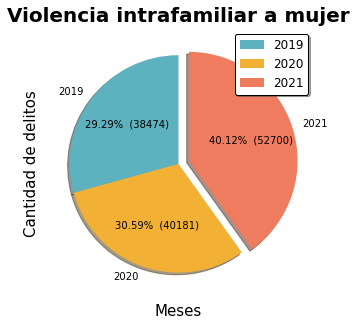

In [24]:
yyyy = [2019,2020,2021]
# mm = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo']
mm = ['Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
delito = 'Violencia intrafamiliar a mujer'
ddelitos.process_data()

ddelitos.date_of_interest = [[2019, 'Octubre', 'red'], [2020,'Marzo','red'] , [2022, 'Marzo','red']]
ddelitos.pie(delito, yyyy,mm);
# ddelitos.bar(delito, yyyy, bbx_a=(1.1,1))
# ddelitos.general_bar(ddelitos.delitos[delito_id], date_interest=True)

<AxesSubplot:title={'center':'Otros robos con fuerza'}, xlabel='Meses', ylabel='Cantidad de delitos'>

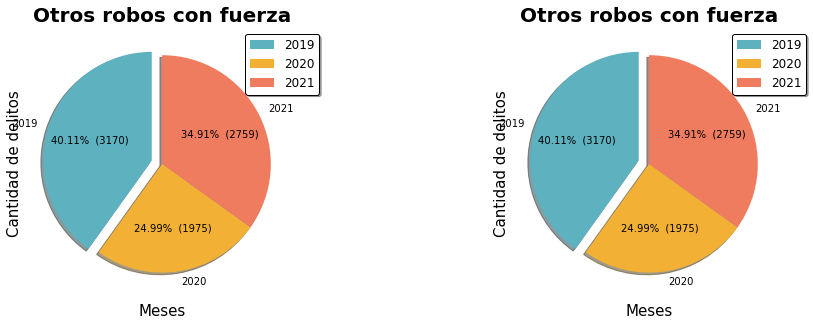

In [27]:
fig, ax = plt.subplots(1,2,figsize=(16, 5))
ddelitos.pie(ddelitos.delitos[delito_id], yyyy, mm, ax=ax[0],bbx_a=(1.1,1))
ddelitos.pie(ddelitos.delitos[delito_id], yyyy, mm, ax=ax[1],bbx_a=(1.1,1))

In [15]:
# ddelitos.show_ordered_delitos(year=2020, month='Abril')
# yyyy = [2017,2018,2019,2020, 2021, 2022]
# ddelitos.bar(delito, yyyy)

In [16]:
# r
# create groupby year and month
# y = [2018, 2019]
# m = ['Enero', 'Febrero', 'Marzo']
# colors = ['#5EB1BF', '#F2B134', '#F07C5F', '#81B29A', '#3D405B','#F2CC8F']

In [17]:
# select year 

# r
# temp_df = pd.DataFrame(r[r.index.get_level_values(1) == month])
# temp_df.iloc[:].values
# une el array [[1],[2]] en uno = [1,2]

# f = temp_df['Homicidios']
# f

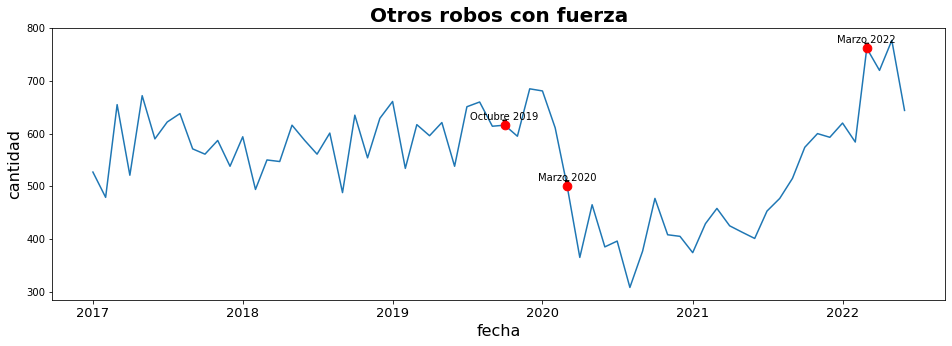

In [18]:
ddelitos.general_plot(ddelitos.delitos[delito_id], date_interest=True)

<AxesSubplot:title={'center':'Homicidios'}, xlabel='fecha', ylabel='cantidad'>

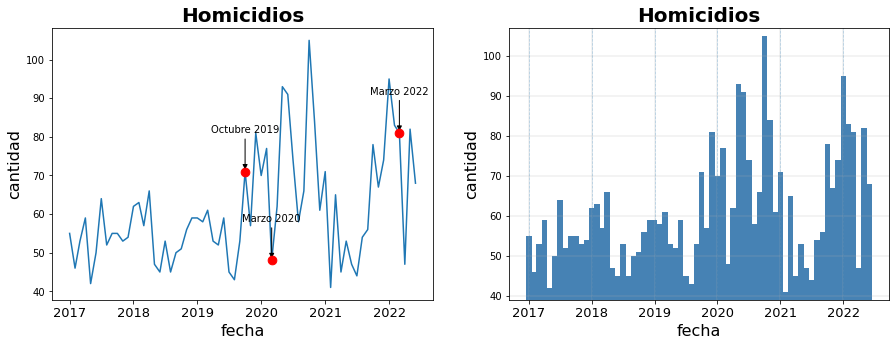

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ddelitos.general_plot('Homicidios',date_interest=True, ax=ax[0])
ddelitos.general_bar('Homicidios', ax=ax[1])

In [20]:
# d = ddelitos.data
# # fecha get month
# de = d[d['fecha'].dt.month == 2]
# # d = d.assign(mes=d['fecha'].dt.month)
# de.head(10)